# Creating a Model

In this notebook we will create our first Neural Net, a very simple one.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.


## Preparation

Before creating features, we will have to import a couple of packages

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp

from typing import List

And we define the **file** we will read from. For now, we'll use the same example as in the previous notebooks. It still very much looks like it did before

In [2]:
file = './data/intro_card.csv'

In [3]:
!cat $file

Date,Amount,Card,Merchant,MCC,Country,Fraud
20200101,1.0,CARD-1,MRC-1,0001,DE,0
20200102,2.0,CARD-2,MRC-2,0002,GB,0
20200103,3.0,CARD-1,MRC-3,0003,DE,1
20200104,4.0,CARD-1,MRC-3,0003,FR,0
20200104,5.0,CARD-2,MRC-2,0002,GB,0
20200106,6.0,CARD-2,MRC-4,,DE,0

## Setting up the features.

We'll begin with the typical steps, by setting up the feature and making a numpy instance out of them. As base base, we'll make a TensorDefinition containing the OneHot encoded 'Merchant' and 'Country', one for the 'Scaled Amount' and one for the 'Fraud' label.

In [4]:
amount   = ft.FeatureSource('Amount', ft.FEATURE_TYPE_FLOAT_32)
mcc      = ft.FeatureSource('MCC', ft.FEATURE_TYPE_CATEGORICAL, default='0000')
country  = ft.FeatureSource('Country', ft.FEATURE_TYPE_CATEGORICAL)
fraud    = ft.FeatureSource('Fraud', ft.FEATURE_TYPE_INT_8)

amount_scaled = ft.FeatureNormalizeScale('Scaled_Amount', ft.FEATURE_TYPE_FLOAT_32, amount)
mcc_oh        = ft.FeatureOneHot('MCC_OH', ft.FEATURE_TYPE_INT_8,  mcc)
country_oh    = ft.FeatureOneHot('Country_OH', ft.FEATURE_TYPE_INT_8, country)

td_oh     = ft.TensorDefinition('Features_OH', [mcc_oh, country_oh])
td_amount = ft.TensorDefinition('Feature_Amount', [amount])
td_label  = ft.TensorDefinition('Feature_Fraud', [fraud])


with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_oh, td_amount, td_label), file, inference=False)
    
# Important ! Define which has the label
ti.label_indexes = 2

2023-03-25 17:57:02.678 eng1n3.common.engine           INFO     Start Engine...
2023-03-25 17:57:02.679 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-03-25 17:57:02.679 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-03-25 17:57:02.680 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ./data/intro_card.csv
2023-03-25 17:57:02.690 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-03-25 17:57:02.692 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays


In [5]:
ti

TensorInstance with shapes: ((6, 7), (6, 1), (6, 1))

### Splitting 
(For giggles with a dataset this small)

In [6]:
train, val, test = ti.split_sequential(2,1)
train, val, test

(TensorInstance with shapes: ((3, 7), (3, 1), (3, 1)),
 TensorInstance with shapes: ((2, 7), (2, 1), (2, 1)),
 TensorInstance with shapes: ((1, 7), (1, 1), (1, 1)))

### DataSet

Next Thing we do is create a `Torch DataSet`. A DataSet is a 'Torch' object that holds our sample data in Tensors. It will be the input to our models. After we created a DataSet, we can access individual items. They now no longer hold Numpy arrays, but Tensors. (No worries Numpy and Torch can share memory, we're not allocating everything twice)

In [7]:
# Creating DataSets from our NumpyInstance
train_ds      = mp.TensorInstanceNumpyDataSet(train)
val_ds        = mp.TensorInstanceNumpyDataSet(val)

Because our `TensorInstanceNumpy` contained 3 arrays, each sample we draw from the DataSet also contains 3 tensors. Here we see the 1st sample. 
- The first tensor is the OneHot encoded County and MCC. It has a size of 7 and type float32.
- The second tensor is the Amount.
- The last tensor is the label.

In [8]:
train_ds[0], train_ds[0][0].shape, train_ds[0][0].dtype

([tensor([1., 0., 0., 0., 1., 0., 0.]), tensor([1.]), tensor([0])],
 torch.Size([7]),
 torch.float32)

## First Model

We create a model in the typical PyTorch manner, we create a new 'nn.Module' class. The `m0d3l` package has a set of pre-prepared models that know how to interpret the input and create same output. 

As user we only need to worry about creating a layer that maps the input of the **Heads** to an output.

The 'Heads' are the first layer, they need to match the input `TensorInstance`. In our example we had 3 lists of which two (the OneHot and Amount) contain the input data and the third list is the labels.

In this first example we will build an extremely simple model that consists of one linear layer only. During the forward pass, we just concatenate the heads, (that way we get a single tensor), run it through a **linear layer** and apply a **sigmoid** activation. 

The input to the linear layer is 8 (7 OneHot + 1 Amount Feature), the output is 1. The ouput of the linear layer is a sort of 'logits', after the sigmoid is becomes a 'probability'.


In [9]:
class FirstModel(mp.BinaryClassifier):
    def __init__(self, tensor_instance: en.TensorInstanceNumpy):
        # Alway call init, very import to correctly initialize the nn.Module
        super(FirstModel, self).__init__(tensor_instance)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        
        # One Linear Layer that maps the output of the heads to [1].
        self.l1 = nn.Linear(sum([h.output_size for h in self.heads]), 1)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail()

    # Create a forward-pass function through the neural net.
    def forward(self, x: List[torch.Tensor]) -> torch.Tensor:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.l1(o)
        o = self.tail(o)
        return o

model = FirstModel(train)
model

FirstModel(
  Number of parameters : 9. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(Name=Features_OH, lc=Binary)
    (1): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
  )
  (l1): Linear(in_features=8, out_features=1, bias=True)
  (tail): Sigmoid()
)

Once the model is created we can run an example through. We can call the model on a specific entry of the DataSet. But we can't just feed all the Numpy arrays in the list, we can only give it the input data, the x-es, not the label (y's). The `get_x` method of the model know which Tensors are in input and extracts those. Let's run the 1st sample of the training set through the model.

We get a result that should correspond to the probability this sample is a fraud. But obviously at this point in time that is not going to make a lot of sense, the model has not been trained yet.

In [10]:
model(model.get_x(train_ds[0])).item()

0.4591464698314667

### Embedding

Looking at the previous example one might wonder why we have the headers. It might look simpler to just concatenate the input and feed it as one string.

Besides being more interesting for the storage, there is an other important reason. In the f3atur3s notebooks we say that we can create feature of type 'Categorical', like for instance the FeatureIndex and FeatureBin. Their output is an integer number, and integer numbers can not be fed as-is to Neural Net, Neural nets insist on working with 'Float' numbers.

In such cases Neural Nets typical use **Embeddings**. We're not going to go into detail on Embeddings here, that might be a topic for a specific notebooks. But as sneak preview, think of an embedding as a multi-dimensional space in which the network can move the values around. The Neural Net can place them so that their relative distances across specific axis express some sort of meaning.

A typical example is the country/capital example. In word embedding in which a Neural Net needs to understand which words co-occur, some words will cluster together. For instance in a two dimensional space countries and capital **could** be mapped as below.

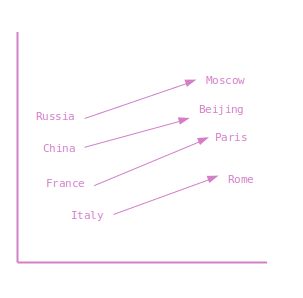

With a bit of imagination, if mmapped like this, we can see that there is a sort of vector mapping that maps the country to the capital, that vector conveys a sort of meaning in the space.

### Second Model

Let try the sample example as previously, but this time encode the country and merchant as an integer rather than a OneHot Encoded vector. We use a `FeatureIndex` instead of a FeatureOneHot.

In [11]:
mcc_i = ft.FeatureIndex('MCC_I', ft.FEATURE_TYPE_INT_16, mcc)
country_i = ft.FeatureIndex('Country_I', ft.FEATURE_TYPE_INT_16, country)

td_i = ft.TensorDefinition('Features_I', [mcc_i, country_i])

with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_i, td_amount, td_label), file, inference=False)
    
# Important ! Define which Numpy array is the label
ti.label_indexes = 2

# Split, again just for giggles
train, val, test = ti.split_sequential(2,1)

# Creating DataSets from our NumpyInstance
train_ds      = mp.TensorInstanceNumpyDataSet(train)
val_ds        = mp.TensorInstanceNumpyDataSet(val)

2023-03-25 17:57:13.323 eng1n3.common.engine           INFO     Start Engine...
2023-03-25 17:57:13.324 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-03-25 17:57:13.325 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-03-25 17:57:13.325 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ./data/intro_card.csv
2023-03-25 17:57:13.333 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-03-25 17:57:13.335 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays


The content of the first list is diferent, we can see that it is of type 'int64' or 'Long', where previously it was a float32. It contains 2 numbers. 

For the first sample the 2 numbers are '1' and '1'. Those correspond to the index of 'MCC 0001' and 'Country DE'.

In [12]:
train_ds[0], train_ds[0][0].shape, train_ds[0][0].dtype

([tensor([1, 1]), tensor([1.]), tensor([0])], torch.Size([2]), torch.int64)

In [13]:
mcc_i.dictionary['0001'], country_i.dictionary['DE']

(1, 1)

Below we create a second model. It's almost exactly the same with the exception of the `create_heads` method call. Here we provide 4 extra parameters:
- dim_ratio (float): Determines the size of the embedding. The size of the embedding is `element_count * dim_ratio`.
- min_dim (int): If the embedding size as calcuated per above is smaller than min_dim, then use min_dim as size
- min_dim (int): If the embedding size as calcuated per above is bigger than max_dim, then use max_dim as size.
- dropout (float): A dropout ratio to apply to the combined embedding output.

In the output we can see that the header layer looks differently. We still have 2 heads. The second head is the amount, the first one is the head for the 'FeatureIndex' features. It contains an Embedding for each feature. 
- The **first** Embedding has a size (5x2). 5 is the number of entries (our 4 MCC codes) + 1 (for unknown). 2 is the size of each embedding. that is 5x 0.5 (the dim_ratio), rounded down.
- The **second** Embedding has a size (4x). 5 is the number of entries (our 3 Countries) + 1. 2 is the (4 * 0.5). If there would have been 3 entries, then the size would still have been 2, the *min_dim* would have kicked in.

An embedding layer will forward through each embedding and then concatenate the ouput. That output will be of size *'sum of the embedding dimensions'* In our case 2 for the MCC Embedding + 2 for the Country Embedding.

After the concatenation this model apply a **dropout** layer with a percentage of 0.1, this layer will randomly change 10% of the node outputs to 0.

The Linear Layer has size of 5. That is 2 (size of MCC embedding) + 2 (size of Country Embedding) + amount after concatenation of all the heads.

In [14]:
class SecondModel(mp.BinaryClassifier):
    def __init__(self, tensor_instance: en.TensorInstanceNumpy):
        super(SecondModel, self).__init__(tensor_instance)
        self.heads = self.create_heads(0.6, 2, 5, 0.1)
        self.l1 = nn.Linear(sum([h.output_size for h in self.heads]), 1)
        self.tail = self.create_tail()

    def forward(self, x: List[torch.Tensor]) -> torch.Tensor:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.l1(o)
        o = self.tail(o)
        return o
    
model = SecondModel(train)
model

SecondModel(
  Number of parameters : 24. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=Features_I, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(5, 2)
          (1): Embedding(4, 2)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
  )
  (l1): Linear(in_features=5, out_features=1, bias=True)
  (tail): Sigmoid()
)

#### Plotting the Embedding
In order to sort of get a feel for the embedding, we can try to plot them. (They conviently have 2 dimensions, so they are something our brains can understand). Let's try for the MCC Index Feature.

The weights can be accessed and converted to numpy. That numpy array has a size 5x2. As we mentioned previously each row is an MCC code, the 0th row is the unknown element. And each row has 2 entries, because that is the size of the embedding. 

In [15]:
mcc_weights = model.heads[0].embedding.embedding_weight(mcc_i).detach().numpy()
mcc_weights.shape, mcc_weights

((5, 2),
 array([[ 1.6443427 , -1.7509258 ],
        [-0.69479156, -1.2563437 ],
        [ 0.2316774 , -0.6560364 ],
        [ 1.6253984 ,  0.6794971 ],
        [-0.9786194 , -0.88241327]], dtype=float32))

We can plot this using a scatter plot. Note that at present, the entries are just randomly mapped, the model has not been trained so this plot means nothing. But as the model is trained, it will shift the x and y coordinates of each of the element so their relative position is useful for solving the problem at hand.

<IPython.core.display.Javascript object>


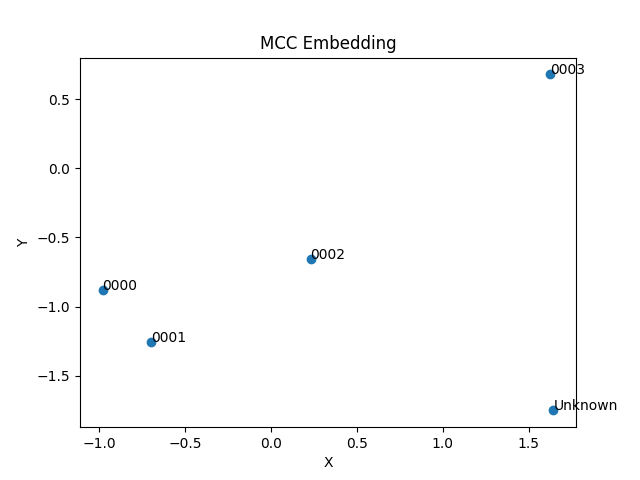

Text(0, 0.5, 'Y')

In [17]:
x, y = mcc_weights[:, 0], mcc_weights[:, 1]

plt.title('MCC Embedding')
plt.scatter(x, y)
for i, l in enumerate(['Unknown'] + list(mcc_i.dictionary.keys())):
    plt.annotate(l, (x[i], y[i]))
plt.xlabel('X')
plt.ylabel('Y')